<a href="https://colab.research.google.com/github/Mfys212/Generasi-Information-Teks-from-Kompas/blob/main/Generasi_Teks_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install pytorch-accelerated
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=cecc0bd5ad207d81519386ee91509b65d95f08d1df69dfb970d4258a5db686cb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 10.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.w

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, size, col, to_timestamp
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests
import os
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

In [ ]:
def download_file(url, file_name):
  response = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(response.content)

github_url = "https://github.com/Mfys212/Generasi-Information-Teks-from-Kompas/raw/main/"
file_names = ["ai.csv", "algoritma.csv", "biologi.csv", "data (3).csv",
              "fisika.csv", "kimia.csv", "komputer.csv", "matematika.csv",
              "pemrograman.csv", "sains.csv", "statistika.csv",
              "teknik.csv", "teknologi.csv"]

if not os.path.exists("downloaded_files"):
  os.makedirs("downloaded_files")

for file_name in file_names:
  file_url = github_url + file_name
  file_path = os.path.join("downloaded_files", file_name)
  print(f"downloading {file_name} ....")
  download_file(file_url, file_path)

downloading ai.csv ....
downloading algoritma.csv ....
downloading biologi.csv ....
downloading data (3).csv ....
downloading fisika.csv ....
downloading kimia.csv ....
downloading komputer.csv ....
downloading matematika.csv ....
downloading pemrograman.csv ....
downloading sains.csv ....
downloading statistika.csv ....
downloading teknik.csv ....
downloading teknologi.csv ....


In [ ]:
df = pd.read_csv("/content/downloaded_files/" + file_names[0])

for file_name in file_names[1:]:
  df_ = pd.read_csv("/content/downloaded_files/" + file_name)
  df = pd.concat([df, df_], ignore_index=True)

spark = SparkSession.builder \
    .appName("Kompas Data") \
    .getOrCreate()

df = spark.createDataFrame(df)

df.printSchema()
df.show()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


root
 |-- Tanggal: string (nullable = true)
 |-- Judul: string (nullable = true)
 |-- Konten: string (nullable = true)
 |-- Link: string (nullable = true)

+-------------------+--------------------+--------------------+--------------------+
|            Tanggal|               Judul|              Konten|                Link|
+-------------------+--------------------+--------------------+--------------------+
|2024-05-09 14:30:00|Kontroversi Reka ...|LONDON, KOMPAS.co...|http://www.kompas...|
|2024-05-06 10:31:00|X Twitter Rilis F...|KOMPAS.com- Media...|http://tekno.komp...|
|2024-05-06 15:01:00|Mengenal Gemini A...|KOMPAS.com- Artif...|http://tekno.komp...|
|2024-05-11 10:05:00|Siapkan Generasi ...|KOMPAS.com -Sekol...|http://www.kompas...|
|2024-05-06 12:41:00|[HOAKS] Foto Rest...|hoaks!Berdasarkan...|http://www.kompas...|
|2024-05-10 15:35:00|[HOAKS] Foto Riha...|hoaks!Berdasarkan...|http://www.kompas...|
|2024-05-07 17:58:00|Hoaks, Spongebob ...|KOMPAS.com- Sebua...|http://www.kompa

In [ ]:
num_rows = df.count()
all_content = "\n".join(df.select("Konten").rdd.map(lambda row: row[0]).collect())

with open("file.txt", "w") as file:
  file.write(all_content)

with open("file.txt", "r") as file:
  content = file.read()

words = content.split()
num_words = len(words)

df = df.withColumn("Tanggal", to_timestamp("Tanggal", "yyyy-MM-dd HH:mm:ss"))
min_date = df.select("tanggal").agg({"tanggal": "min"}).collect()[0][0]
max_date = df.select("tanggal").agg({"tanggal": "max"}).collect()[0][0]

print("Jumlah berita:", num_rows)
print("Jumlah kata dalam berita:", num_words)
print("Berita paling lama:", min_date)
print("Berita paling baru:", max_date)

Jumlah berita: 28839
Jumlah kata dalam berita: 8913668
Berita paling lama: 2013-05-03 15:58:00
Berita paling baru: 2024-05-12 21:00:00


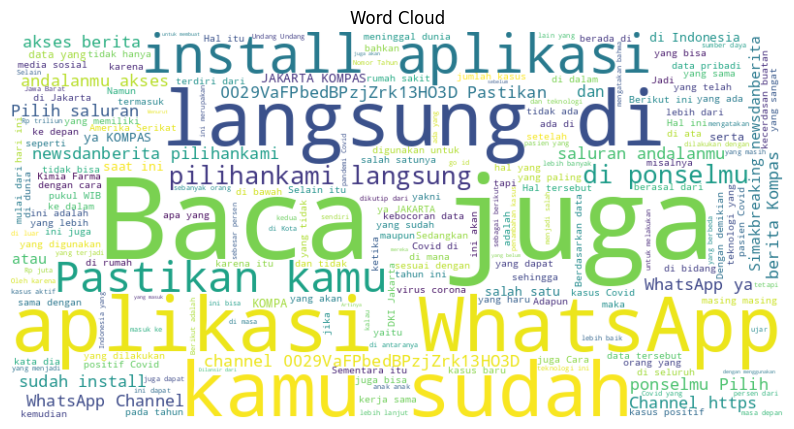

In [ ]:
with open("file.txt", "r") as file:
  content = file.read()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(content)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('flax-community/gpt2-small-indonesian')
model = GPT2LMHeadModel.from_pretrained('flax-community/gpt2-small-indonesian')

train_data_file = "file.txt"
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_data_file,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

training_args = TrainingArguments(
    output_dir="/content",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()
config = GPT2Config()
trainer.save_model("/content")
config.save_pretrained("/content")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
500,3.138400
1000,3.038900
1500,2.971400
2000,2.943500
2500,2.933200
3000,2.928200
3500,2.936500
4000,2.900900
4500,2.890300
5000,2.876100


Step,Training Loss
500,3.138400
1000,3.038900
1500,2.971400
2000,2.943500
2500,2.933200
3000,2.928200
3500,2.936500
4000,2.900900
4500,2.890300
5000,2.876100


In [ ]:
model = GPT2LMHeadModel.from_pretrained("/content")

def generate_response(prompt, max_length=50, temperature=0.7):
  input_ids = tokenizer.encode(prompt, return_tensors="pt")

  output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=temperature)
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  return response

generate_response("Fisika adalah")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Fisika adalah ilmu yang mempelajari tentang materi dan energi. Fisika juga mempelajari tentang materi dan energi. Fisika juga mempelajari tentang materi dan energi.Baca juga:Pengertian dan Rumus Energi Kinetik, Tetapan, Momentum, dan Momentum GabungEnergi Kin'

In [ ]:
generate_response("Teknologi saat ini")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Teknologi saat ini, kata dia, juga harus mampu menjawab tantangan dan kebutuhan masyarakat.Baca juga:Menko PMK: Indonesia Butuh Banyak SDM Digital untuk Hadapi Revolusi Industri 4.0"Kita harus mampu menjawab tantangan dan kebutuhan masyarakat. Kita harus mampu menjawab'

In [ ]:
generate_response("Ilmu pengetahuan di indonesia")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Ilmu pengetahuan di indonesia sudah berkembang pesat, bahkan sudah ada yang mencapai skala internasional. Hal ini dibuktikan dengan adanya beberapa penemuan penting yang berasal dari Indonesia.Salah satu penemuan penting yang berasal dari Indonesia adalah alat ukur tekanan. Alat ukur tekanan ini digunakan untuk mengukur tekanan'

In [ ]:
generate_response("Artificial Intelligence")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Artificial Intelligence(AI) atau kecerdasan buatan.AI adalah teknologi yang dapat melakukan tugas-tugas yang sebelumnya tidak dapat dilakukan oleh manusia.AI dapat melakukan tugas-tugas yang sebelumnya tidak dapat dilakukan oleh manusia. Misalnya, AI dapat melakukan tugas-tugas'

In [ ]:
generate_response("Perkembangan sains di dunia")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Perkembangan sains di dunia saat ini, menurut dia, tidak hanya berkutat pada bidang fisika, kimia, dan biologi saja. Namun, juga bidang matematika, astronomi, dan biologi.Baca juga:5 Jurusan Kuliah yang Cocok untuk Anak IPA"Jadi, sains itu'